In [121]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
# Add the path to the folder containing img_preprocessing_util_functions.py
module_path = str(Path(r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\src\preprocessing"))
sys.path.append(module_path)
import img_preprocessing_util_functions as img_utils
import cv2
import numpy as np
from pathlib import Path
from torchvision import transforms
from PIL import Image
import torch
from model import get_embedding_model
import random
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
import imgaug

# Set the seed globally for imgaug
imgaug.seed(42)

# Example augmentation
import imgaug.augmenters as iaa

In [201]:
def preprocess_single_image(image_path, steps, switches, hyperparams, model_type):
    """
    Full preprocessing pipeline for a single image, including optional model-specific preprocessing.
    
    Parameters:
        image_path (str): Path to the input image.
        steps (list): List of preprocessing steps to apply (e.g., 'skeletonize', 'augment').
        switches (dict): Switches for enabling/disabling specific preprocessing steps.
        hyperparams (dict): Hyperparameters for specific preprocessing methods (e.g., CLAHE settings).
        model_type (str, optional): Target model type for specific preprocessing ('VGG16', 'EfficientNet', etc.).
    
    Returns:
        np.ndarray or torch.Tensor: Preprocessed image ready for the model.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    # Step 1: Grayscale and binary processing (if enabled)
    if switches.get('grayscale', False):
        image = img_utils.rgb_to_grey(image)
    if switches.get('grey_to_binary', False):
        image = img_utils.grey_to_binary(image)

    # Ensure the image is in uint8 format
    image = (image * 255).astype(np.uint8) if image.dtype == bool else image

    # Step 2: Apply additional preprocessing steps
    for step in steps:
        if switches.get(step, False):
            if step == 'clahe':
                clahe = cv2.createCLAHE(
                    clipLimit=hyperparams[step]['clipLimit'], 
                    tileGridSize=(hyperparams[step]['tileGridSize'], hyperparams[step]['tileGridSize'])
                )
                image = clahe.apply(image)
            elif step == 'gaussian_blur':
                image = cv2.GaussianBlur(image, (5, 5), hyperparams[step]['sigma'])
            elif step == 'adaptive_threshold':
                image = cv2.adaptiveThreshold(
                    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
                    blockSize=hyperparams[step]['blockSize'], C=hyperparams[step]['C']
                )
            elif step == 'skeletonize':
                image = img_utils.skeletonize_image(image)
            elif step == 'augment':
                image = img_utils.augment_image(image)

    # Step 3: Model-specific preprocessing (if applicable)
    if model_type:
        image = apply_model_specific_preprocessing(image, model_type)
    

    return image


def apply_model_specific_preprocessing(image, model_type):
    """
    Applies model-specific preprocessing to the image.
    
    Parameters:
        image (np.ndarray): Preprocessed image.
        model_type (str): Model type ('VGG16', 'EfficientNet', 'InceptionV3', etc.).
    
    Returns:
        np.ndarray or torch.Tensor: Image processed for the target model.
    """
    if model_type == 'VGG16':
        resized_image = cv2.resize(image, (224, 224))
        if resized_image.ndim == 2 or resized_image.shape[-1] == 1:
            final_image = np.stack((resized_image,) * 3, axis=-1)
        else:
            final_image = resized_image
        mean = np.array([123.68, 116.779, 103.939])
        return final_image - mean

    elif model_type == 'EfficientNet':
        resized_image = cv2.resize(image, (224, 224))
        normalized_image = resized_image / 255.0
        if normalized_image.ndim == 2 or normalized_image.shape[-1] == 1:
            final_image = np.stack((normalized_image,) * 3, axis=-1)
        else:
            final_image = normalized_image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (final_image - mean) / std

    elif model_type == 'InceptionV3':
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        preprocess = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])
        return preprocess(image)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
def image_tensor(image):
    tensor = torch.from_numpy(image).float()
    tensor = tensor.permute(2, 0, 1)
    tensor = tensor.unsqueeze(0) 
    return tensor
    
steps = ['clahe', 'gaussian_blur', 'adaptive_threshold', 'skeletonize']
switches = {
    'grayscale': True,
    'grey_to_binary': True,
    'clahe': False,
    'gaussian_blur': False,
    'adaptive_threshold': True,
    'skeletonize': True,
    'augment': True
}
hyperparams = {
    'clahe': {'clipLimit': 2.0, 'tileGridSize': 8},
    'adaptive_threshold': {'blockSize': 11, 'C': 2},
    'gaussian_blur': {'sigma': 1.5}
}
model_type = 'VGG16'  # Change to the target model type

In [179]:
def predict(model, anchor, test, threshold):
    a, p, t = model(anchor, anchor, test)
    distance = torch.nn.functional.pairwise_distance(a, t)
    print('distance:', distance)
    if distance < threshold:
        print("The image is Genuine")
    else:
        print("The image is Forged")


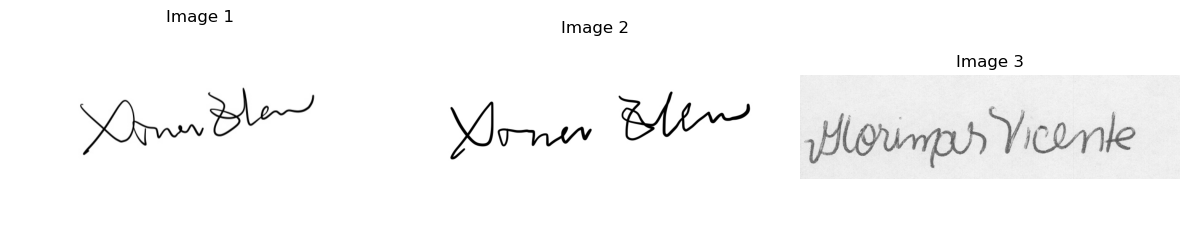

In [212]:

# Paths to the images
image_path1 = r"C:\Users\marui\Brown\DATA2050\test\zhao_T2.jpg" 
image_path2 = r"C:\Users\marui\Brown\DATA2050\test\zhap_F2.jpg"
# image_path1 = r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\data\Cedar\full_org\original_2_2.png" #俗
# image_path2 = r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\data\Cedar\full_forg\forgeries_2_10.png"
# image_path3 = r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\data\Cedar\full_org\original_2_12.png"
# image_path1 = r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\data\Real_Fake_Signature\Signature Images\01T1.jpeg" #雅
# image_path2 = r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\data\Real_Fake_Signature\Signature Images\01F9.jpeg"
# image_path3 = r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\data\Real_Fake_Signature\Signature Images\01T5.jpeg"

# Read images using OpenCV
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
image3 = cv2.imread(image_path3)

# Convert images from BGR to RGB (OpenCV loads images in BGR format)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(12, 4))  # Set the figure size

# Display image 1
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.imshow(image1)
plt.title("Image 1")
plt.axis("off")  # Turn off the axis

# Display image 2
plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title("Image 2")
plt.axis("off")

# Display image 3
plt.subplot(1, 3, 3)
plt.imshow(image3)
plt.title("Image 3")
plt.axis("off")

# Show the figure
plt.tight_layout()  # Adjust spacing between plots
plt.show()

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the trained model
model = get_embedding_model(2).to(device)
model.load_state_dict(torch.load(r"C:\Users\marui\Brown\DATA2050\CitizensBank-Fraud-Signature-Detection\src\vgg_2\weights.pth"))
model.eval()

C:\Users\marui\AppData\Local\Temp\ipykernel_74068\1244034.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\marui\Brown\DATA205

TripletSignatureEmbeddingModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, st

In [213]:
preprocessed_image1 = preprocess_single_image(image_path1, steps, switches, hyperparams, model_type)
preprocessed_image2 = preprocess_single_image(image_path2, steps, switches, hyperparams, model_type)
preprocessed_image3 = preprocess_single_image(image_path3, steps, switches, hyperparams, model_type)
preprocessed_image1 = image_tensor(preprocessed_image1).to(device)
preprocessed_image2 = image_tensor(preprocessed_image2).to(device)
preprocessed_image3 = image_tensor(preprocessed_image3).to(device)

In [214]:
a, b, c = model(preprocessed_image1, preprocessed_image2, preprocessed_image3)

In [215]:
print(a, b, c)

tensor([[-0.0682,  0.7093]], device='cuda:0', grad_fn=<SplitBackward0>) tensor([[-0.2315,  0.9725]], device='cuda:0', grad_fn=<SplitBackward0>) tensor([[0.7198, 1.0581]], device='cuda:0', grad_fn=<SplitBackward0>)


In [ ]:
predict(model, preprocessed_image1, preprocessed_image2, 0.74857)

distance: tensor([0.3097], device='cuda:0', grad_fn=<NormBackward1>)
The image is Genuine


: 

In [206]:
predict(model, preprocessed_image1, preprocessed_image3, 0.74857)

distance: tensor([0.2483], device='cuda:0', grad_fn=<NormBackward1>)
The image is Genuine
